# DAY1の内容でKickstarter Projectsを解いてみる

## Kickstarter Projectsとは

・クラウドファンディングが成功するかどうか(state)を予測するコンペ  
・URL: https://www.kaggle.com/kemical/kickstarter-projects

## DAY1の内容

・目的変数と説明変数の関係を確認するためのグラフを作成する  
・分類の場合は, ロジスティック回帰  
・質的変数が扱えないアルゴリズムを使う場合は, ダミー変数に置き換える  
・識別精度を確認する(混同行列を作成し, Accuracy, Recall, Precisionを求める)  

## まだやっていないこと

・欠損値・異常値の適切な処理   
・パラメータのチューニング(ホールドアウト法, 交叉検証)  
・カテゴリーが多すぎる時のダミー変数の処理 など 

-----------------------------------------------------------------------------------------------------------------------------

In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 分類問題における性能評価に関する関数
from sklearn.preprocessing import StandardScaler

## データ読み込み

In [10]:
initialdf = pd.read_csv("archive/ks-projects-201801.csv")
initialdf.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 基礎集計

In [23]:
initialdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [15]:
#データの平均, 標準偏差, 最大値, 最小値などを集計
initialdf.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


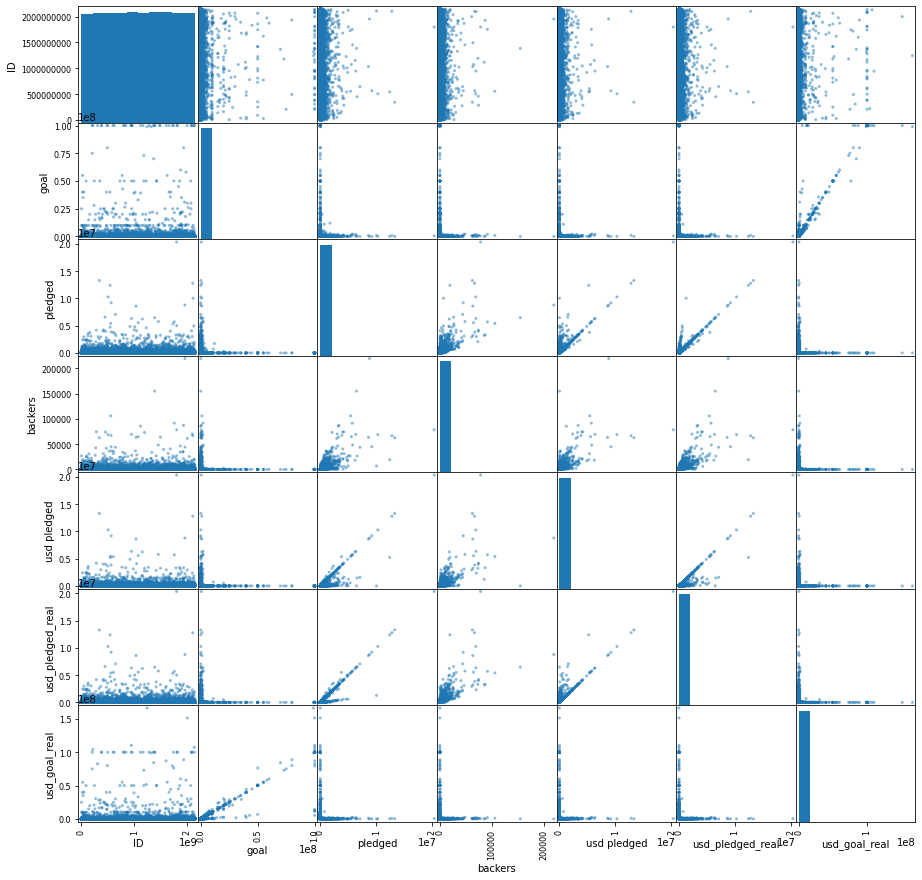

In [21]:
# 散布図行列
pd.plotting.scatter_matrix(initialdf, figsize=(15,15))
plt.show()

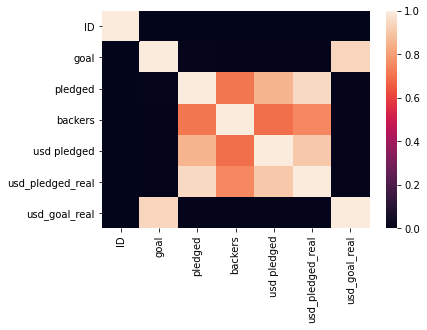

In [19]:
# 相関係数をヒートマップにして可視化
sns.heatmap(initialdf.corr())
plt.show()

In [20]:
# 相関係数を確認
initialdf.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


## 目的変数を決める

In [56]:
initialdf['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

・目的変数(state)の種類が多いため, 「successful」と「failed」のみにする

In [57]:
pd_df_sf=initialdf.loc[(initialdf["state"] =="failed" )| (initialdf["state"]=="successful")]
pd_df_sf.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


## 予測に用いる説明変数を決める

説明変数に用いる変数の選択  
・欠損値のないもの  
・質的変数の中でカテゴリーの多すぎないもの

In [58]:
pd_df_sf.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


In [59]:
for i in pd_df_sf.columns:
    print('column名:{}, Dtype:{}, カテゴリ数:{}個'.format(i, pd_df_sf[i].dtype, len(pd_df_sf[i].value_counts())))

column名:ID, Dtype:int64, カテゴリ数:331675個
column名:name, Dtype:object, カテゴリ数:329594個
column名:category, Dtype:object, カテゴリ数:159個
column名:main_category, Dtype:object, カテゴリ数:15個
column名:currency, Dtype:object, カテゴリ数:14個
column名:deadline, Dtype:object, カテゴリ数:3102個
column名:goal, Dtype:float64, カテゴリ数:7539個
column名:launched, Dtype:object, カテゴリ数:331255個
column名:pledged, Dtype:float64, カテゴリ数:59839個
column名:state, Dtype:object, カテゴリ数:2個
column名:backers, Dtype:int64, カテゴリ数:3926個
column名:country, Dtype:object, カテゴリ数:23個
column名:usd pledged, Dtype:float64, カテゴリ数:89573個
column名:usd_pledged_real, Dtype:float64, カテゴリ数:98659個
column名:usd_goal_real, Dtype:float64, カテゴリ数:44651個


In [60]:
pd_df_sf.isnull().sum()

ID                    0
name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

結果より, 説明変数は, main_category(object), currency(object), goal, pledged, backers, country(object), usd_pledged_real, usd_goal_realを用いることにする

[Discussion]  
Pledge > Goals means the kick-starter has raised enough funds so it's successful. So at least don't use the pledge column.  
Pledgeを使うとリークにつながるので, 使うなというDiscussionがあった  
URL:https://www.kaggle.com/kemical/kickstarter-projects/discussion/170598  

そのため説明変数から, pledge, usd_pledged_realを外す

In [87]:
X_df = pd_df_sf[["main_category", "currency", "goal", "backers", "country", "usd_goal_real"]]
y_df = pd_df_sf[["state"]]
X_df.head()
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   main_category  331675 non-null  object 
 1   currency       331675 non-null  object 
 2   goal           331675 non-null  float64
 3   backers        331675 non-null  int64  
 4   country        331675 non-null  object 
 5   usd_goal_real  331675 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.7+ MB


## 前処理(ダミー変数化)

In [88]:
X_df_d = pd.get_dummies(X_df)
print(len(y_df))
X_df_d.info()

331675
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   goal                        331675 non-null  float64
 1   backers                     331675 non-null  int64  
 2   usd_goal_real               331675 non-null  float64
 3   main_category_Art           331675 non-null  uint8  
 4   main_category_Comics        331675 non-null  uint8  
 5   main_category_Crafts        331675 non-null  uint8  
 6   main_category_Dance         331675 non-null  uint8  
 7   main_category_Design        331675 non-null  uint8  
 8   main_category_Fashion       331675 non-null  uint8  
 9   main_category_Film & Video  331675 non-null  uint8  
 10  main_category_Food          331675 non-null  uint8  
 11  main_category_Games         331675 non-null  uint8  
 12  main_category_Journalism    331675 non-null  uint8  
 13  main_ca

In [89]:
X_df_d.head()

,goal,backers,usd_goal_real,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1000.0,0,1533.95,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,15,30000.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,3,45000.00,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,1,5000.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,224,50000.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## モデルの作成

In [93]:
# 線形回帰
y = y_df.values
print(y[:5])
X = X_df_d.values
print(X[:5])
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

[['failed']
 ['failed']
 ['failed']
 ['failed']
 ['successful']]
[[1.00000e+03 0.00000e+00 1.53395e+03 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00]
 [3.00000e+04 1.50000e+01 3.00000e+04 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
  0.00000e+00 0.00000e+00 0.0000

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=None, penalty='none',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [94]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

正答率（Accuracy） = 90.245%
適合率（Precision） = 83.094%
再現率（Recall） = 95.218%
F1値（F1-score） = 88.744%


In [98]:
# 予測値と正解のクロス集計（混同行列）
#failed
#successful
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

conf_mat

,予測 = failed,予測 = successful
正解 = failed,171769,25950
正解 = successful,6406,127550
